# [通し課題]

8. DAY2、3で学んだことの取り組み • 交差検証、ホールドアウト法などで汎化性能を確認する  
 • 欠測値と異常値を確認し、適切に処理する  
 • DAY2、3で学んだアルゴリズムを利用してモデルをつくり、DAY1宿題提出時の精度と比較する  
 • 交差検証によるパラメータチューニングを行う  
 • パラメータチューニング後のモデルによって、精度および結果の評価を行う  
 • その他、精度の向上ができるような処理に取り組み、精度を上げる  
 • できたところまでをNotebookでまとめ、宿題として提出する  
 • 前回から取り組んだ内容・工夫、精度がどのように変化したかのコメントを Notebookに含めること  
 • 15分程度，受講者同士で通し課題の進捗を見せ合う時間を設けます  
9. DAY4では、DAY3宿題の提出ファイルを元に、最終発表を実施いただ

# 0. DAY1~２での実施事項


In [12]:
#********************************************************************
# pandas,numpy,matplotlib,codecs,sklearnの各ライブラリをインポート
#********************************************************************

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import codecs as cd
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix
import seaborn as sns

#********************************************************************
#.該当課題のデータを読み込む
#********************************************************************
#201801のデータを読み込んでみる
with cd.open('ks-projects-201801.csv', 'r', 'utf-8', 'ignore') as f18:
    df_f18 = pd.read_csv(f18)
#df_f18 = pd.read_csv('ks-projects-201801.csv')

#********************************************************************
#.欠損値がある行は、とりあえずなくしてみる
#********************************************************************
#１個でも欠損値がある行はとりあえず削除してみる。
df_f18_dna = df_f18.dropna(how='any')

#********************************************************************
#.成功（'successful'）と失敗（'failed'）に絞って考える。
#********************************************************************
#成功だけを抽出したDFと失敗だけを抽出したDF
df_f18_success = df_f18_dna[df_f18_dna['state']=='successful']
df_f18_failed =  df_f18_dna[df_f18_dna['state']=='failed']
#両方を結合
df_f18_SorF = pd.concat([df_f18_success,df_f18_failed])

#********************************************************************
#.'state'をカテゴリ変数（文字列）から数値化してみる。
#********************************************************************
#LabelEncoderのインスタンスを生成
le = LabelEncoder()

#stateに出てくるカテゴリを覚えて
#stateを数値に変換
le = le.fit(df_f18_SorF['state'])
df_f18_SorF['state'] = le.transform(df_f18_SorF['state'])

#********************************************************************
#.'deadline' 'launched' の項目から期間'days'を日数で割り出す
#********************************************************************
# 'deadline' 'launched' の項目をdatetimeに変更
df_f18_SorF['deadline'] = pd.to_datetime(df_f18_SorF['deadline'], errors = 'coerce')
df_f18_SorF['launched'] = pd.to_datetime(df_f18_SorF['launched'], errors = 'coerce')
# 'deadline' 'launched' の間の日数を示す'period'を作成
df_f18_SorF['period'] = df_f18_SorF['deadline'] - df_f18_SorF['launched']

days = []

#'period'の日数を'days'に抽出
for i in df_f18_SorF.index:
    days.append(df_f18_SorF['period'][i].days)
#'days'列を追加
df_f18_SorF['days'] = days

#####################################
#異常値を除いたデータフレームを作る。
#####################################
#goalの異常値を除いたデータフレーム
df_train = df_f18_SorF[df_f18_SorF['goal']<99999999]

#####################################
#country,main_category,categoryをOne-Hotに変換する。
#####################################
df_train = pd.get_dummies(df_train, columns=['country', 'category', 'main_category'])


In [13]:

#********************************************************************
#.ロジスティック回帰で分類してみる。
#********************************************************************

#目的変数'state'を正解としてyに格納
y = df_train['state'].values
#説明変数'goal','backers','days','country_GB','country_HK','country_SG','country_US','main_category_rate','category_rate'を入力としてXに格納
X = df_train[['goal','days','country_GB','country_HK','country_SG','country_US','main_category_Art',\
                  'main_category_Comics','main_category_Dance','main_category_Design','main_category_Film & Video',\
                  'main_category_Games','main_category_Music','main_category_Theater',\
                 'category_Anthologies','category_Chiptune','category_Classical Music','category_Comic Books','category_Country & Folk',\
                  'category_Dance','category_Indie Rock','category_Jazz','category_Letterpress','category_Performances','category_Plays',\
                  'category_Residencies','category_Tabletop Games','category_Theater','category_Typography']].values

#ロジスティック回帰で学習
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234)
clf.fit(X, y)

#********************************************************************
#.予測精度または識別精度を確認する
#　混同行列を作成し、Accuracy、Recall、Precisionを求める
#********************************************************************
# 学習した結果を使って説明変数を入力して予測
y_est = clf.predict(X)

#混同行列を作成
tn, fp, fn, tp = confusion_matrix(y, y_est).ravel()
print(fn, fp)
print(tn, tp)

#'Accuracy、Recall、Precisionを求めて表示
print('Accuracy  = {:.3f}%'.format(100 * (tn+tp)/(tn+fp+fn+tp)))
print('Recall    = {:.3f}%'.format(100 * (tp)/(fn+tp)))
print('Precision = {:.3f}%'.format(100 * (tp)/(fp+tp)))

47591 29609
93594 36176
Accuracy  = 62.700%
Recall    = 43.186%
Precision = 54.991%


# １．交差検証、ホールドアウト法などで汎化性能を確認する  

## 1.1. 欠測値と異常値を確認し、適切に処理する 

##  1.2. DAY2、3で学んだアルゴリズムを利用してモデルをつくり、DAY1宿題提出時の精度と比較する

### 1.3. 交差検証によるパラメータチューニングを行う

In [15]:
# ホールドアウト法に関する関数
from sklearn.model_selection import train_test_split
# 交差検証法に関する関数
from sklearn.model_selection import KFold
# 回帰問題における性能評価に関する関数
from sklearn.metrics import mean_absolute_error

ホールドアウト法で、最終的に性能を見るためのテストデータを別にする。（３０％をテストデータに）  
パラメータチューニングには５分割で交差検証を行う。

In [44]:
train_label = df_train['state']
train_data = df_train.drop(['state','name','currency','deadline','goal','launched','pledged','backers','usd pledged','usd_pledged_real','period'], axis=1)

#目的変数'state'を正解としてyに格納
y = train_label.values
#説明変数'goal','backers','days','country_rate','main_category_rate','category_rate'を入力としてXに格納
X = train_data.values
#X = df_train[['goal', 'backers','days','country_rate','main_category_rate','category_rate']].values

# 全データのうち、30%をテストデータにする
test_size = 0.3

# ホールドアウト法を実行（テストデータはランダム選択）
#X_train : 学習用データの説明変数
#X_test : テスト用データの説明変数
#y_train : 学習用データの目的変数
#y_test : テスト用データの目的変数
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234) 

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(144879, 199) (62091, 199) (144879,) (62091,)


In [45]:
#現在の最大表示列数の出力
pd.get_option("display.max_columns")

#最大表示列数の指定（ここでは50列を指定）
pd.set_option('display.max_columns', 1000)

display(df_train.head())

,ID,name,currency,deadline,goal,launched,pledged,state,backers,usd pledged,usd_pledged_real,usd_goal_real,period,days,country_AT,country_AU,country_BE,country_CA,country_CH,country_DE,country_DK,country_ES,country_FR,country_GB,country_HK,country_IE,country_IT,country_JP,country_LU,country_MX,country_NL,country_NO,country_NZ,country_SE,country_SG,country_US,category_3D Printing,category_Academic,category_Accessories,category_Action,category_Animals,category_Animation,category_Anthologies,category_Apparel,category_Apps,category_Architecture,category_Art,category_Art Books,category_Audio,category_Bacon,category_Blues,category_Calendars,category_Camera Equipment,category_Candles,category_Ceramics,category_Children's Books,category_Childrenswear,category_Chiptune,category_Civic Design,category_Classical Music,category_Comedy,category_Comic Books,category_Comics,category_Community Gardens,category_Conceptual Art,category_Cookbooks,category_Country & Folk,category_Couture,category_Crafts,category_Crochet,category_DIY,category_DIY Electronics,category_Dance,category_Design,category_Digital Art,category_Documentary,category_Drama,category_Drinks,category_Electronic Music,category_Embroidery,category_Events,category_Experimental,category_Fabrication Tools,category_Faith,category_Family,category_Fantasy,category_Farmer's Markets,category_Farms,category_Fashion,category_Festivals,category_Fiction,category_Film & Video,category_Fine Art,category_Flight,category_Food,category_Food Trucks,category_Footwear,category_Gadgets,category_Games,category_Gaming Hardware,category_Glass,category_Graphic Design,category_Graphic Novels,category_Hardware,category_Hip-Hop,category_Horror,category_Illustration,category_Immersive,category_Indie Rock,category_Installations,category_Interactive Design,category_Jazz,category_Jewelry,category_Journalism,category_Kids,category_Knitting,category_Latin,category_Letterpress,category_Literary Journals,category_Literary Spaces,category_Live Games,category_Makerspaces,category_Metal,category_Mixed Media,category_Mobile Games,category_Movie Theaters,category_Music,category_Music Videos,category_Musical,category_Narrative Film,category_Nature,category_Nonfiction,category_Painting,category_People,category_Performance Art,category_Performances,category_Periodicals,category_Pet Fashion,category_Photo,category_Photobooks,category_Photography,category_Places,category_Playing Cards,category_Plays,category_Poetry,category_Pop,category_Pottery,category_Print,category_Printing,category_Product Design,category_Public Art,category_Publishing,category_Punk,category_Puzzles,category_Quilts,category_R&B,category_Radio & Podcasts,category_Ready-to-wear,category_Residencies,category_Restaurants,category_Robots,category_Rock,category_Romance,category_Science Fiction,category_Sculpture,category_Shorts,category_Small Batch,category_Software,category_Sound,category_Space Exploration,category_Spaces,category_Stationery,category_Tabletop Games,category_Taxidermy,category_Technology,category_Television,category_Textiles,category_Theater,category_Thrillers,category_Translations,category_Typography,category_Vegan,category_Video,category_Video Art,category_Video Games,category_Wearables,category_Weaving,category_Web,category_Webcomics,category_Webseries,category_Woodworking,category_Workshops,category_World Music,category_Young Adult,category_Zines,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,main_category_Food,main_category_Games,main_category_Journalism,main_category_Music,main_category_Photography,main_category_Publishing,main_category_Technology,main_category_Theater
5,1000014025,Monarch Espresso Bar,USD,2016-04-01,50000.0,2016-02-26 13:38:27,52375.0,1,224.0,52375.00,52375.00,50000.00,34 days 10:21:33,34,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [46]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV

## 特長量を選択する（埋め込み法）

In [47]:
# estimatorにモデルをセット
# LassoCVを使って、正則化の強さは自動決定
estimator = LassoCV(normalize=True, cv=10)

# モデルの情報を使って特徴選択を行う場合は、SelectFromModelを使う
# 今回は係数が1e-5以下である特徴を削除する
# 係数のしきい値はthresholdで指定する
sfm = SelectFromModel(estimator, threshold=1e-5)

In [48]:
# fitで特徴選択を実行
sfm.fit(X_train, y_train)

C:\Users\junka\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


SelectFromModel(estimator=LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=True, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False),
        norm_order=1, prefit=False, threshold=1e-05)

In [49]:
# get_support関数で使用する特徴のインデックスを使用
# Trueになっている特徴が使用する特徴
sfm.get_support()

array([False, False,  True,  True,  True,  True, False, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True, False,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [50]:
# 削除すべき特徴の名前を取得 
removed_idx  = ~sfm.get_support()
train_data.columns[removed_idx]

Index(['ID', 'usd_goal_real', 'country_CA', 'country_CH',
       'category_Children's Books', 'category_Comics', 'category_Crafts',
       'category_Design', 'category_Fabrication Tools', 'category_Fashion',
       'category_Food', 'category_Glass', 'category_Graphic Design',
       'category_Literary Spaces', 'category_Music', 'category_Photography',
       'category_Poetry', 'category_Pop', 'category_Romance',
       'category_Taxidermy', 'category_Woodworking', 'category_World Music',
       'main_category_Art', 'main_category_Film & Video',
       'main_category_Games', 'main_category_Journalism',
       'main_category_Publishing'],
      dtype='object')

In [42]:
# LASSOで得た各特徴の係数の値を確認してみよう
# 係数の絶対値を取得
abs_coef = np.abs(sfm.estimator_.coef_)
abs_coef

array([0.00000000e+00, 1.78913204e-08, 2.06290147e-07, 3.78342318e-05,
       2.19839704e-07, 2.25832913e-07, 0.00000000e+00, 4.22654122e-03,
       7.11365548e-02, 1.31414964e-02, 1.32788830e-04, 0.00000000e+00,
       0.00000000e+00, 2.84585683e-02, 1.88089454e-02, 4.04946859e-02,
       4.09585034e-02, 3.55401138e-02, 7.75025828e-02, 1.70546850e-02,
       1.08954140e-01, 7.61024231e-02, 0.00000000e+00, 4.88603631e-02,
       5.13795106e-02, 0.00000000e+00, 0.00000000e+00, 2.47754026e-02,
       5.25940708e-02, 4.74683746e-02, 2.60988737e-02, 1.09927220e-01,
       5.67595568e-02, 1.33909100e-01, 1.00939551e-01, 7.12182846e-02,
       2.03100101e-01, 4.45310717e-02, 2.31803579e-01, 7.31403983e-02,
       6.01595466e-02, 1.62181979e-01, 6.31689218e-02, 2.98500494e-02,
       3.22383079e-02, 1.01686392e-02, 1.54025664e-01, 9.97163913e-02,
       6.40611250e-02, 0.00000000e+00, 4.47270005e-02, 2.03268121e-01,
       2.06719354e-03, 1.68449465e-01, 1.69015074e-02, 8.49476356e-02,
      

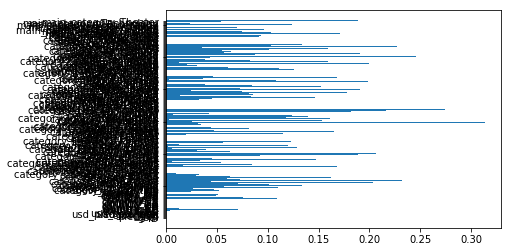

In [43]:
# 係数を棒グラフで表示
plt.barh(np.arange(0, len(abs_coef)), abs_coef, tick_label=train_data.columns.values)
plt.show()

In [17]:
# scikit-learnに入力するために整形
#X = X.reshape(-1,1)

# グループ数を設定（今回は5分割）
n_split = 5 

#評価値と試行回数を初期化
cross_valid_acc = 0
cross_valid_rec = 0
cross_valid_pre = 0
test_num = 1

# SVMのパラメータ設定
C = 5
kernel = "rbf"
gamma = 1


# テスト役を交代させながら学習と評価を繰り返す
for train_idx, test_idx in KFold(n_splits=n_split, random_state=1234).split(X_train, y_train):
    #学習用データ
    X_valid_train, y_valid_train = X[train_idx], y[train_idx] 
    #テスト用データ
    X_valid_test, y_valid_test = X[test_idx], y[test_idx]     
    

    # 学習用データを使ってSVMでモデルを学習
    # SVMで学習
    clf_SVM = SVC(C=C, kernel=kernel, gamma=gamma)
    clf_SVM.fit(X_valid_train, y_valid_train)

    # テストデータに対する予測を実行
    y_pred_test = clf_SVM.predict(X_valid_test)

    #混同行列を作成
    tn, fp, fn, tp = confusion_matrix(y_valid_test, y_pred_test).ravel()
    print(fn, fp)
    print(tn, tp)

    Acc = 100 * (tn+tp)/(tn+fp+fn+tp)
    Rec = 100 * (tp)/(fn+tp)
    Pre = 100 * (tp)/(fp+tp)

    #'Accuracy、Recall、Precisionを求めて表示
    print('N  = %s'%test_num)
    print('Accuracy  = {:.3f}%'.format(Acc))
    print('Recall    = {:.3f}%'.format(Rec))
    print('Precision = {:.3f}%'.format(Pre))
    
    cross_valid_acc += Acc #後で平均を取るためにAccuracyを加算
    cross_valid_rec += Rec #後で平均を取るためにRecallを加算
    cross_valid_pre += Pre #後で平均を取るためにPreciionを加算
    test_num += 1

# 各指標の平均値を最終的な汎化誤差値とする
final_acc = cross_valid_acc / n_split
final_rec = cross_valid_rec / n_split
final_pre = cross_valid_pre / n_split
print("Cross Validation Accuracy  = %s"%round(final_acc, 3))
print("Cross Validation Recall  = %s"%round(final_rec, 3))
print("Cross Validation Precision  = %s"%round(final_pre, 3))

952 3372
13108 11544
N  = 1
Accuracy  = 85.077%
Recall    = 92.382%
Precision = 77.393%
950 3082
13916 11028
N  = 2
Accuracy  = 86.085%
Recall    = 92.069%
Precision = 78.157%
1217 4379
11434 11945
N  = 3
Accuracy  = 80.687%
Recall    = 90.754%
Precision = 73.174%
947 4977
12504 10547
N  = 4
Accuracy  = 79.555%
Recall    = 91.761%
Precision = 67.940%
542 4360
10960 13113
N  = 5
Accuracy  = 83.082%
Recall    = 96.031%
Precision = 75.047%
Cross Validation Accuracy  = 82.897
Cross Validation Recall  = 92.599
Cross Validation Precision  = 74.342


In [ ]:
# scikit-learnに入力するために整形
#X = X.reshape(-1,1)

# グループ数を設定（今回は5分割）
n_split = 5 

#評価値と試行回数を初期化
cross_valid_acc = 0
cross_valid_rec = 0
cross_valid_pre = 0
test_num = 1

for j in [1,2,3,4]:
    # SVMのパラメータ設定
    C = j
    kernel = "rbf"
    gamma = 1

    print('C  = {:.3f}%'.format(j))
    print('gamma    = {:.3f}%'.format(gamma))
    
    # テスト役を交代させながら学習と評価を繰り返す
    for train_idx, test_idx in KFold(n_splits=n_split, random_state=1234).split(X_train, y_train):
        #学習用データ
        X_valid_train, y_valid_train = X[train_idx], y[train_idx] 
        #テスト用データ
        X_valid_test, y_valid_test = X[test_idx], y[test_idx]     
    

        # 学習用データを使ってSVMでモデルを学習
        # SVMで学習
        clf_SVM = SVC(C=C, kernel=kernel, gamma=gamma)
        clf_SVM.fit(X_valid_train, y_valid_train)
        
        # テストデータに対する予測を実行
        y_pred_test = clf_SVM.predict(X_valid_test)
        
        #混同行列を作成
        tn, fp, fn, tp = confusion_matrix(y_valid_test, y_pred_test).ravel()
        print(fn, fp)
        print(tn, tp)
        
        Acc = 100 * (tn+tp)/(tn+fp+fn+tp)
        Rec = 100 * (tp)/(fn+tp)
        Pre = 100 * (tp)/(fp+tp)
        
        #'Accuracy、Recall、Precisionを求めて表示
        print('N  = %s'%test_num)
        print('Accuracy  = {:.3f}%'.format(Acc))
        print('Recall    = {:.3f}%'.format(Rec))
        print('Precision = {:.3f}%'.format(Pre))
        
        cross_valid_acc += Acc #後で平均を取るためにAccuracyを加算
        cross_valid_rec += Rec #後で平均を取るためにRecallを加算
        cross_valid_pre += Pre #後で平均を取るためにPreciionを加算
        test_num += 1
        
    # 各指標の平均値を最終的な汎化誤差値とする
    final_acc = cross_valid_acc / n_split
    final_rec = cross_valid_rec / n_split
    final_pre = cross_valid_pre / n_split
    print("Cross Validation Accuracy  = %s"%round(final_acc, 3))
    print("Cross Validation Recall  = %s"%round(final_rec, 3))
    print("Cross Validation Precision  = %s"%round(final_pre, 3))

C  = 1.000%
gamma    = 1.000%
799 3444
13036 11697
N  = 1
Accuracy  = 85.357%
Recall    = 93.606%
Precision = 77.254%
830 3109
13889 11148
N  = 2
Accuracy  = 86.406%
Recall    = 93.071%
Precision = 78.193%
1068 4438
11375 12094
N  = 3
Accuracy  = 80.997%
Recall    = 91.886%
Precision = 73.155%
808 5060
12421 10686
N  = 4
Accuracy  = 79.748%
Recall    = 92.970%
Precision = 67.865%
472 4423
10897 13183
N  = 5
Accuracy  = 83.106%
Recall    = 96.543%
Precision = 74.878%
Cross Validation Accuracy  = 83.123
Cross Validation Recall  = 93.615
Cross Validation Precision  = 74.269
C  = 2.000%
gamma    = 1.000%
944 3379
13101 11552
N  = 6
Accuracy  = 85.081%
Recall    = 92.446%
Precision = 77.369%
912 3081
13917 11066
N  = 7
Accuracy  = 86.220%
Recall    = 92.386%
Precision = 78.222%
1194 4375
11438 11968
N  = 8
Accuracy  = 80.780%
Recall    = 90.928%
Precision = 73.230%
923 4964
12517 10571
N  = 9
Accuracy  = 79.682%
Recall    = 91.970%
Precision = 68.046%
531 4380
10940 13124
N  = 10
Accuracy  

### 1.4. パラメータチューニング後のモデルによって、精度および結果の評価を行う

### 1.5. その他、精度の向上ができるような処理に取り組み、精度を上げる

### 1.6. できたところまでをNotebookでまとめ、宿題として提出する  

### 1.7. 前回から取り組んだ内容・工夫、精度がどのように変化したかのコメントを Notebookに含めること 

### 1.8. 15分程度，受講者同士で通し課題の進捗を見せ合う時間を設けます